In [1]:
df = basic_info('sales_df')
df.head()

2020-07-01 08:34:09,756 - kedro.io.data_catalog - INFO - Loading data from `sales_df` (CSVDataSet)...
shape: (2935849, 6)
--------------
unique numbers
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64
--------------
num of duplicated: 6
--------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


- 全部nullの行
- 重複のある行
- 外れ値がある行
- 全て同じ値のカラム

を削除

In [2]:
df.dropna(how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(how='all', axis=1, inplace=True)
df = remove_outlier(df, 'item_price')
df.drop(df.columns[df.nunique() == 1], axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

### 2. 特徴量選択
xgboostのfeature_importanceで上位の特徴量を取得

2020-07-01 08:34:19,474 - kedro.io.data_catalog - INFO - Loading data from `x_train` (CSVDataSet)...
2020-07-01 08:34:37,846 - kedro.io.data_catalog - INFO - Loading data from `y_train` (CSVDataSet)...
[08:34:44] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


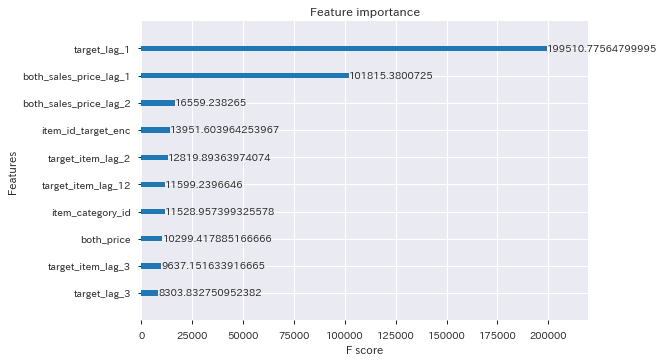

In [3]:
X_train = catalog.load('x_train')
y_train = catalog.load('y_train').target
features = select_features(X_train, y_train, top_n=10, is_regression=True)

### 3. train vs test
trainデータとtestデータの差を確認

- X_train, X_testのデータ量(shape)
- ラベルの割合
- X_train, X_testのカラムの違い

を出力

In [4]:
X_val = catalog.load('x_val')
y_val = catalog.load('y_val').target
diff_train_test(X_train, y_train, X_val, y_val, is_regression=True)

2020-07-01 08:36:04,246 - kedro.io.data_catalog - INFO - Loading data from `x_val` (CSVDataSet)...
2020-07-01 08:36:04,909 - kedro.io.data_catalog - INFO - Loading data from `y_val` (CSVDataSet)...
========shape=========
train shape: (6121853, 44)
test shape: (234916, 44)
========column difference=========
train - test:  []
test - train:  []


重ね合わせたヒストグラムで各特徴量の、train vs testの分布の違いを確認

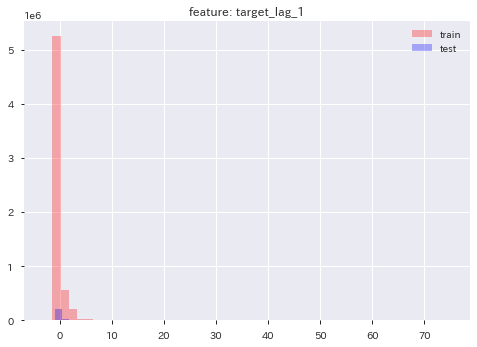

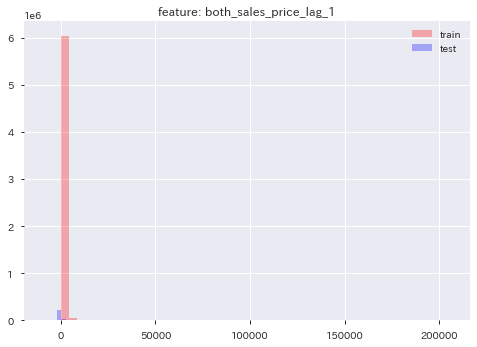

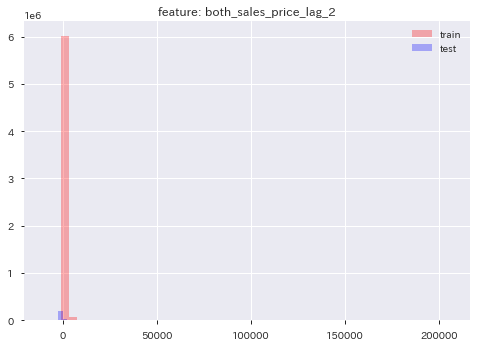

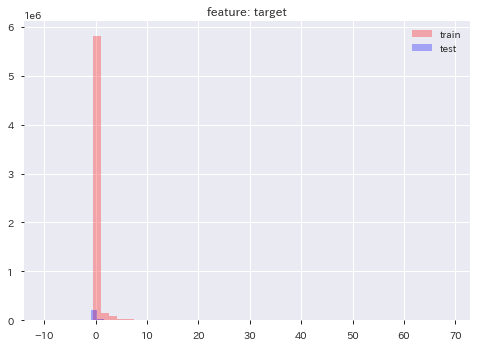

In [5]:
# サンプルとして重要な特徴量3つで試す
sample_features = features[:3]
hist_train_test(X_train[sample_features], y_train,
                X_val[sample_features], y_val, is_regression=True, bins=50)

### 4. ラベル付きデータのヒストグラム

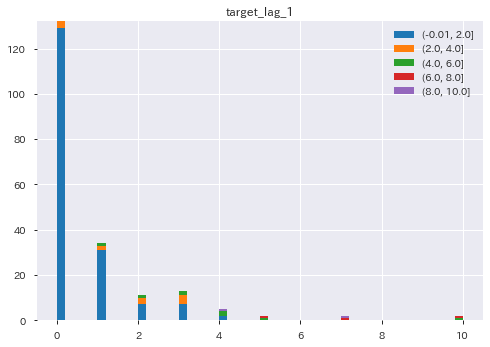

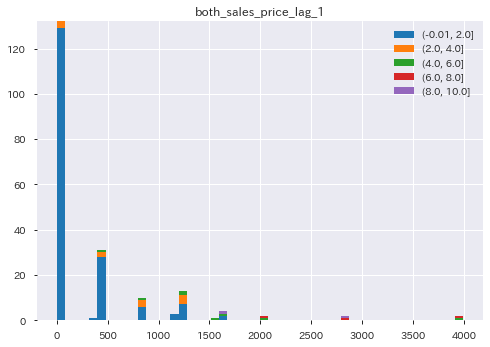

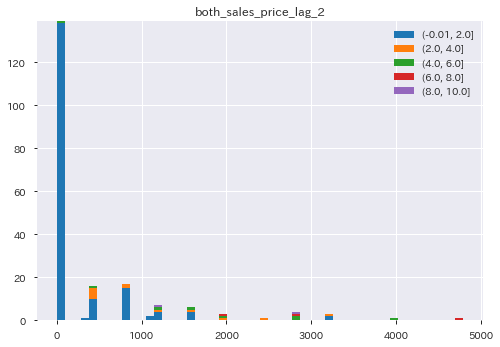

In [6]:
# サンプルとして重要な特徴量3つで試す
sample_features = features[:3]
hist_with_label(X_train.loc[:200, sample_features], y_train.loc[:200], bins=50, is_regression=True)

### 5. 二次元に描写
umap or t-sneを使う

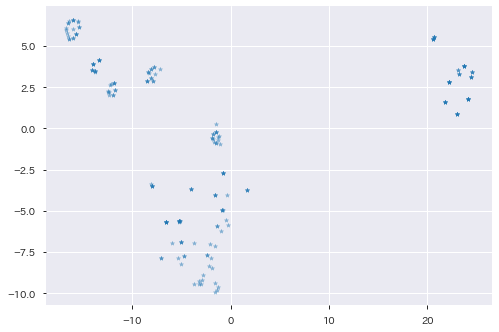

In [7]:
# ラベルなし
plot_2d(X_train.loc[:200, features], method='tsne')

/home/matoba/miniconda3/envs/kaggle/lib/python3.7/importlib/__init__.py:127: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  return _bootstrap._gcd_import(name[level:], package, level)
/home/matoba/miniconda3/envs/kaggle/lib/python3.7/site-packages/umap/spectral.py:106: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'CPUDispatcher' requested from: 'numba.targets.registry', please update to use 'numba.core.registry' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  ) == numba.targets.registry.CPUDispatcher and scipy.sparse.isspmatrix(data):
/home/matoba/miniconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully 

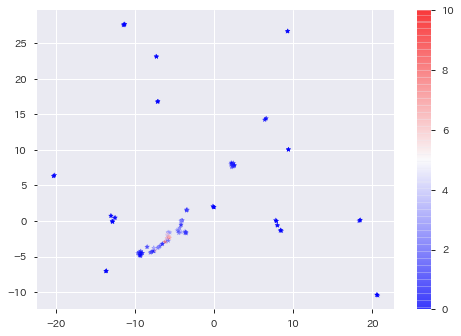

In [8]:
# ラベルあり
plot_2d(X_train.loc[:200, features], y_train.loc[:200])

### 6. 時系列データを可視化
seasonal, trendなどに分解もする

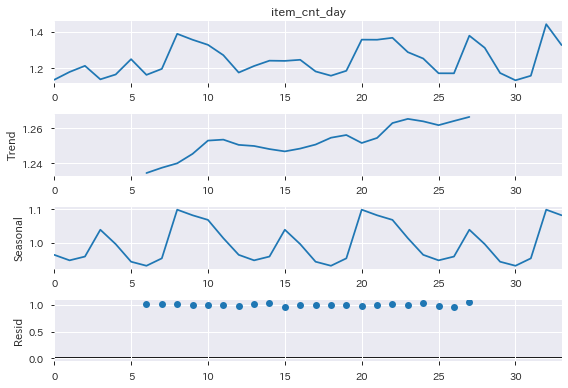

In [9]:
s = df.groupby('date_block_num')['item_cnt_day'].mean()
res = sm.tsa.seasonal_decompose(s, period=12, model="multiplicative")
_ = res.plot()

2020-07-01 08:37:01,775 - kedro.io.data_catalog - INFO - Loading data from `x_test` (CSVDataSet)...


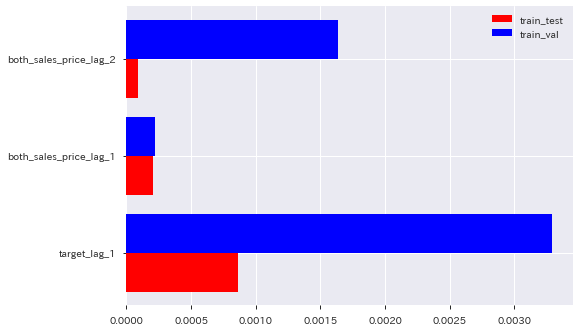

In [10]:
X_test = catalog.load('x_test')
sample_features = features[:3]
# smaller is similar
plot_kl_divergence(X_train[sample_features], X_val[sample_features], X_test[sample_features])